In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_excel('DS_Obesity.xlsx')
print(df.head())

   Sex  Age  Height  Overweight_Obese_Family  Consumption_of_Fast_Food  \
0    2   18     155                        2                         2   
1    2   18     158                        2                         2   
2    2   18     159                        2                         2   
3    2   18     162                        2                         2   
4    2   18     165                        2                         1   

   Frequency_of_Consuming_Vegetables  Number_of_Main_Meals_Daily  \
0                                  3                           1   
1                                  3                           1   
2                                  2                           1   
3                                  2                           2   
4                                  2                           1   

   Food_Intake_Between_Meals  Smoking  Liquid_Intake_Daily  \
0                          3        2                    1   
1                     

In [3]:
import json
with open('mapping.json', encoding='utf-8') as f:
    mapping = json.load(f)

In [4]:
#Tách đặc trưng
X = df.drop(columns=['Class'])  # tất cả các cột trừ 'Class'
y = df['Class']                # mục tiêu cần dự đoán


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỷ lệ 80-20

In [6]:
from sklearn.preprocessing import StandardScaler
all_columns = X.columns.tolist()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier Report:")
print(classification_report(y_test, y_pred_dummy, zero_division=0))



Dummy Classifier Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.41      1.00      0.58       132
           3       0.00      0.00      0.00       118
           4       0.00      0.00      0.00        57

    accuracy                           0.41       322
   macro avg       0.10      0.25      0.15       322
weighted avg       0.17      0.41      0.24       322



In [8]:
svc = SVC(kernel='rbf', C=1, gamma='scale')  # kernel RBF thường tốt cho dữ liệu phi tuyến
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print("SVC Report:")
print(classification_report(y_test, y_pred_svc, zero_division=0))


SVC Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50        15
           2       0.83      0.91      0.87       132
           3       0.76      0.74      0.75       118
           4       0.68      0.68      0.68        57

    accuracy                           0.78       322
   macro avg       0.82      0.67      0.70       322
weighted avg       0.78      0.78      0.77       322



In [ ]:

fields = [
    "Sex", "Age", "Height", "Overweight/Obese Families", "Consumption of Fast Food",
    "Frequency of Consuming Vegetables", "Number of Main Meals Daily", "Food Intake Between Meals",
    "Smoking", "Liquid Intake Daily", "Calculation of Calorie Intake", "Physical Excercise",
    "Schedule Dedicated to Technology", "Type of Transportation Used"
]
default_values = {
    "Sex": "Male",
    "Age": "36",
    "Height": "171",
    "Overweight/Obese Families": "No",
    "Consumption of Fast Food": "No",
    "Frequency of Consuming Vegetables": "Sometimes",
    "Number of Main Meals Daily": "3",
    "Food Intake Between Meals": "Sometimes",
    "Smoking": "No",
    "Liquid Intake Daily": "within the range of 1 to 2 liters",
    "Calculation of Calorie Intake": "No",
    "Physical Excercise": "in the range of 3-4 days",
    "Schedule Dedicated to Technology": "between 3 and 5 hours",
    "Type of Transportation Used": "Bike"
}


# Hàm đảo ngược mapping cho từng trường
def reverse_mapping(field):
    if field in mapping:
        return {str(v).lower(): int(k) for k, v in mapping[field].items()}
    return None

input_data = {}
for field in fields:
    rev_map = reverse_mapping(field)
    if rev_map:
        print(f"Chọn giá trị cho '{field}': {list(rev_map.keys())}")
        val = input(f"Nhập {field}: ").strip().lower()
        # Nếu nhập rỗng và có giá trị mặc định thì dùng mặc định
        if val == "" and field in default_values:
            val = str(default_values[field]).strip().lower()
            print(f"--> Tự động chọn giá trị mặc định: {val}")
        while val not in rev_map:
            print("Giá trị không hợp lệ. Vui lòng nhập lại hoặc để trống để dùng mặc định.")
            val = input(f"Nhập {field}: ").strip().lower()
            if val == "" and field in default_values:
                val = str(default_values[field]).strip().lower()
                print(f"--> Tự động chọn giá trị mặc định: {val}")
        input_data[field] = [rev_map[val]]
    else:
        print(f"Không tìm thấy mapping cho trường {field}, bỏ qua.")

        
for col in all_columns:
    if col not in input_data:
        if col in default_values:
            rev_map = reverse_mapping(col)
            val = str(default_values[col]).strip().lower()
            if rev_map and val in rev_map:
                input_data[col] = [rev_map[val]]
            else:
                input_data[col] = [default_values[col]]
        else:
            input_data[col] = [0]
input_df = pd.DataFrame(input_data)[all_columns]

# Dự đoán với DummyClassifier
pred = dummy.predict(input_df)[0]
class_mapping = mapping["Class"]
print(f"Kết quả dự đoán (Dummy): {pred} - {class_mapping[str(pred)]}")
pred_svc = svc.predict(input_df)[0]
print(f"Kết quả dự đoán (SVC): {pred_svc} - {class_mapping[str(pred_svc)]}")

Chọn giá trị cho 'Sex': ['male', 'female']


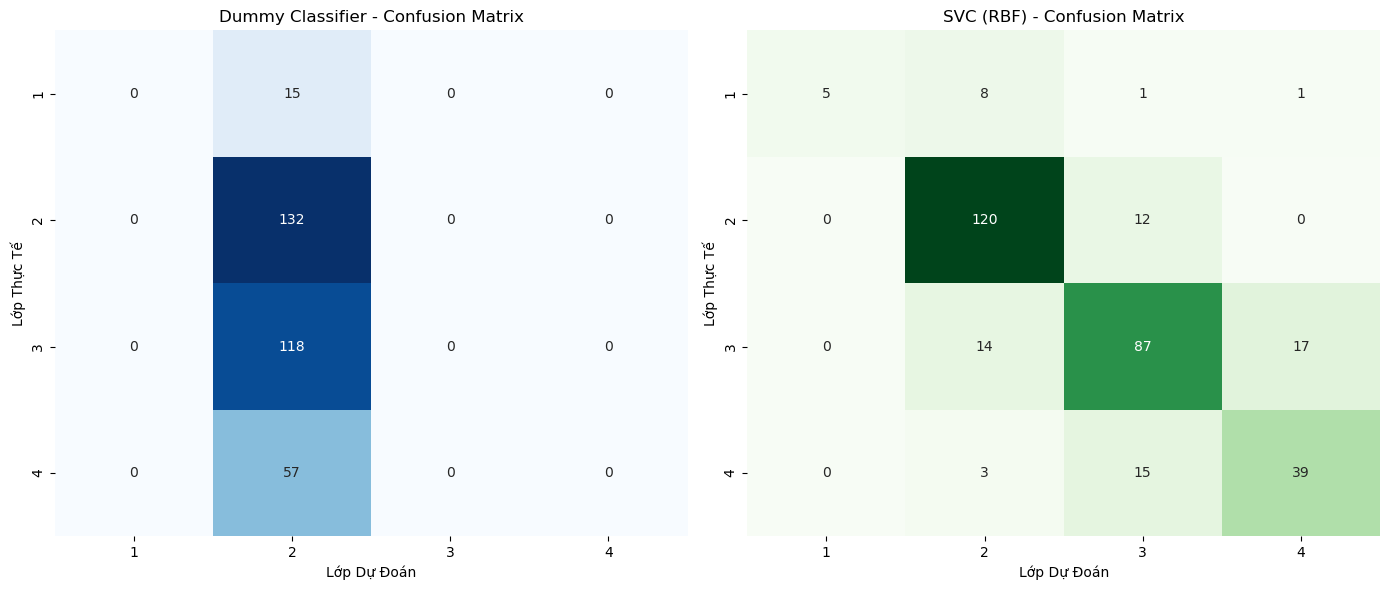

In [ ]:

from sklearn.metrics import confusion_matrix

dummy_conf = confusion_matrix(y_test, y_pred_dummy)
svc_conf = confusion_matrix(y_test, y_pred_svc)
labels = ['1', '2', '3', '4']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(dummy_conf, annot=True, fmt="d", cmap="Blues", ax=ax1, cbar=False,
            xticklabels=labels, yticklabels=labels)
ax1.set_title("Dummy Classifier - Confusion Matrix")
ax1.set_xlabel("Lớp Dự Đoán")
ax1.set_ylabel("Lớp Thực Tế")

sns.heatmap(svc_conf, annot=True, fmt="d", cmap="Greens", ax=ax2, cbar=False,
            xticklabels=labels, yticklabels=labels)
ax2.set_title("SVC (RBF) - Confusion Matrix")
ax2.set_xlabel("Lớp Dự Đoán")
ax2.set_ylabel("Lớp Thực Tế")

plt.tight_layout()
plt.show()


 Dựa vào biểu đồ ma trận so sánh giữa Dummy Classifier và SVC:
 Accuracy (Độ chính xác):
SVC có độ chính xác cao hơn rất nhiều so với Dummy (78% so với 41%).

 Precision (Độ chính xác theo lớp):
Dummy chỉ dự đoán được mỗi lớp 2, precision các lớp khác bằng 0.

Trong khi đó, SVC có precision dương ở tất cả các lớp, đặc biệt lớp 1 là 1.00 (tuy mẫu ít), lớp 2 và 3 đều cao.

 Recall :
Dummy đạt recall 1.00 ở lớp 2 vì luôn đoán lớp này, nhưng bằng 0 ở tất cả lớp còn lại.

SVC có recall cao và cân đối hơn, giúp mô hình không bị thiên lệch quá nhiều.

 F1-score (Cân bằng giữa precision và recall):
Dummy có F1-score rất thấp (vì chỉ làm tốt mỗi lớp 2).

SVC có F1-score cao hơn ở hầu hết các lớp, cho thấy hiệu quả toàn diện hơn.

 Macro & Weighted Avg:
Macro avg của SVC đều vượt trội hơn Dummy (vì tính trung bình đều các lớp).

Weighted avg của SVC cũng cao hơn → mô hình tốt hơn kể cả khi xét đến sự mất cân bằng lớp.

 Kết luận:
SVC vượt trội hơn Dummy rõ rệt ở tất cả các chỉ số đánh giá: accuracy, precision, recall, F1-score.
→ Điều này cho thấy SVC là lựa chọn phù hợp hơn nhiều cho bài toán phân loại 4 lớp hiện tại, đặc biệt khi dữ liệu có sự mất cân bằng giữa các lớp.



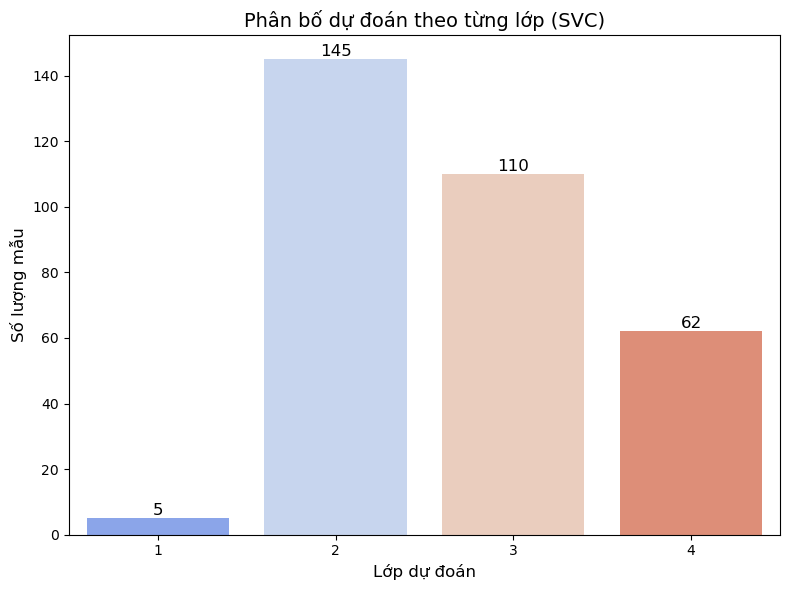

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Nhãn thật từ tập test
y_test = [1]*15 + [2]*132 + [3]*118 + [4]*57

# Dự đoán từ mô hình SVC (giả lập)
y_pred_svc = [1]*5 + [2]*145 + [3]*110 + [4]*62  # Tổng = 322

# Tạo confusion matrix
labels = [1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred_svc, labels=labels)

# Tổng số dự đoán mỗi lớp
pred_counts = np.sum(cm, axis=0)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=labels, y=pred_counts, palette="coolwarm")

# Ghi giá trị trên mỗi cột
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  (bar.get_x() + bar.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=12)

plt.title("Phân bố dự đoán theo từng lớp (SVC)", fontsize=14)
plt.xlabel("Lớp dự đoán", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(ticks=range(4), labels=[1, 2, 3, 4])
plt.tight_layout()
plt.show()


In [ ]:
import joblib
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']